### Preprocess tiles

In [1]:
import numpy as np
from PIL import Image

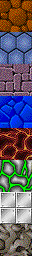

In [2]:
# Background

# Some styles are ignored
images = [Image.open(f"original/BOOM Graphics/BGPattern 0{i+2}.png").convert("RGBA") for i in range(8)]
final_image = Image.fromarray(np.vstack(images))
final_image.save("image/background.png")
Image.open("image/background.png").convert("RGBA")

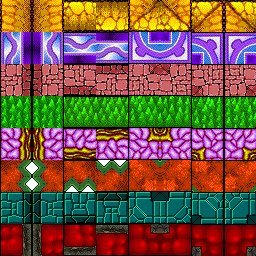

In [3]:
# Border

images = [Image.open(f"original/BOOM Graphics/Border 0{i+1}.png").convert("RGBA") for i in range(8)]
final_image = Image.fromarray(np.vstack(images))
final_image.save("image/border.png")
Image.open("image/border.png").convert("RGBA")

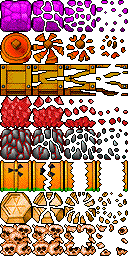

In [4]:
# Breakable

image = Image.open(f"original/BOOM Graphics/Breakable Blocks.png").convert("RGBA")
image.save("image/breakable_wall.png")
Image.open("image/breakable_wall.png").convert("RGBA")

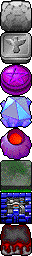

In [5]:
# Solid

image = Image.open(f"original/BOOM Graphics/Fixed Blocks.png").convert("RGBA")
image = Image.fromarray(np.vstack(np.split(np.array(image), 8, axis = 1)))

image.save("image/solid_wall.png")
Image.open("image/solid_wall.png").convert("RGBA")

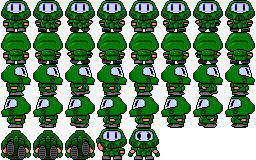

In [6]:
# Player

void = np.array([[[255, 255, 255, 0]] * 32] * 32, dtype=np.uint8)

for i in range(2):
    image = Image.open(f"original/BOOM Graphics/Player{i+1}.png").convert("RGBA")
    line = np.hstack(np.split(np.array(image), 2) + [void] * 2)
    image = Image.fromarray(np.vstack(np.split(line, 5, axis = 1)))
    image.save(f"image/player{i+1}.png")
Image.open(f"image/player{i}.png")

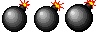

In [7]:
# Bomb

image = Image.open("original/BOOM Graphics/Bomb.png")
image.save("image/bomb.png")
Image.open("image/bomb.png")

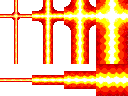

In [8]:
# Laser

image = Image.open("original/BOOM Graphics/Explosion.png")
image.save("image/laser.png")
Image.open("image/laser.png")

(96, 480)


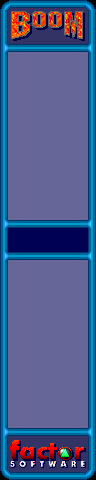

In [9]:
# Panel

image = Image.open("original/BOOM Graphics/Panel.png")
image.save("image/panel.png")
print(image.size)
Image.open("image/panel.png")

In [10]:
96 / 32, 480 / 32

(3.0, 15.0)

In [12]:
# Player head

for i in range(2):
    image = Image.open(f"original/BOOM Graphics/Player {i+1} Head.png").convert("RGBA")
    image.save(f"image/player_head{i+1}.png")

Image.open("image/player_head1.png").convert("RGBA")

In [13]:
Image.fromarray(np.array(image)[0:21, 0:31])

In [14]:
image.size

(32, 21)

In [15]:
# Heart

image = Image.open(f"original/BOOM Graphics/Heart Icons.png").convert("RGBA")
np_image = np.array(image)[0:16]
image = Image.fromarray(np.hstack((np_image[:, 0:16], np_image[:, 18:34], np_image[:, 36:52])))  # Delete weird extra space
image.save("image/heart.png")
Image.open("image/heart.png").convert("RGBA")

###  Levels and maze

In [1]:
import json
import xml.etree.ElementTree as ET

import bomberman

pygame 2.0.1 (SDL 2.0.14, Python 3.9.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
players = {
    "X": 1,
    "Y": 2,
}

klasses = {
    "1": bomberman.model.entity.SolidWall,
    "2": bomberman.model.entity.BreakableWall,
}

undecoded = set()


def parse_repr(maze_repr):
    """from original to actual"""
    maze = bomberman.model.maze.Maze((13, 15))
    for n, c in enumerate(maze_repr):
        if c == "0":
            continue
        i = n // 15
        j = n % 15
        if c in players:
            maze.player_spawns[players[c]] = bomberman.model.entity.Position(i, j)
            continue

        klass = klasses.get(c)
        if not klass:
            print(f"Undecoded '{c}' at ({i}, {j})")
            undecoded.add(c)
            continue

        maze.add_entity(klass(maze, bomberman.model.entity.Position(i, j)))

    return maze

In [3]:
def parse_xml(level_xml):
    level = {}

    key = None
    for child in level_xml:
        if child.tag == "key":
            assert key is None
            key = child.text
        else:
            value = child.text
            if child.tag == "integer":
                value = int(value)
            assert key is not None
            level[key] = value
            key = None

    return level

In [5]:
tree = ET.parse("original/BOOM Levels.xml")
root = tree.getroot()
levels = root.find("dict").find("array")

game = []

for i, level_xml in enumerate(levels):
    print("======================")
    print(i)
    level = parse_xml(level_xml)
    meta_data = {
        "style": i // 10,
        "maze_id": i + 1,
        "time": level["Time"],
    }

    maze = parse_repr(level["GridDescString"])
    print(maze)
    maze.save(f"maze/{meta_data['maze_id']}.txt")
    game.append(meta_data)
    
print("Undecoded chars:")
print(undecoded)
with open("game/boom.json", "w") as f:
    json.dump(game, f, indent=True)



0
Undecoded '3' at (2, 9)
Undecoded '3' at (4, 1)
Undecoded 'A' at (4, 4)
Undecoded '3' at (6, 8)
Undecoded 'A' at (8, 10)
Undecoded '3' at (8, 13)
Undecoded '3' at (9, 4)
X| | | |B| |B| | | | |B| | | 
 |S|B|S| |S|B|S| |S|B|S| |S| 
 | | | |B| |B| |B| | | | | |B
 |S|B|S| |S| |S| |S|B|S| |S| 
B| | | | | | | |B| | | |B| |B
 |S| |S|B|S| |S| |S|B|S| |S| 
 | | |B| | |B| | | |B| | | | 
B|S| |S|B|S| |S| |S|B|S| |S| 
B| | |B| | | |B|B| | | | | |B
 |S|B|S| |S| |S|B|S|B|S| |S| 
 | | | |B| |B| | | | | |B|B| 
B|S|B|S| |S| |S|B|S| |S| |S| 
 | |B| | |B| | | | |B| | | |Y
1
Undecoded '3' at (0, 7)
Undecoded 'A' at (2, 7)
Undecoded '3' at (3, 4)
Undecoded '3' at (3, 10)
Undecoded 'A' at (4, 7)
Undecoded '3' at (6, 5)
Undecoded '3' at (6, 7)
Undecoded '3' at (6, 9)
Undecoded 'A' at (8, 7)
Undecoded '3' at (9, 4)
Undecoded '3' at (9, 10)
Undecoded 'A' at (10, 7)
Undecoded '3' at (12, 7)
X| | |B| |B|B| |B|B| | |B|B|B
 |S|B|S|B|S|B|S|B|S|B|S|B|S|B
 | |B|B|B|B| | | |B|B|B|B| |B
B|S| |S| |S|B|S|B|S| |S| |S| 


74
Undecoded 'J' at (0, 7)
Undecoded '3' at (4, 2)
Undecoded '3' at (4, 12)
Undecoded 'H' at (5, 0)
Undecoded '3' at (5, 2)
Undecoded 'G' at (5, 10)
Undecoded '3' at (5, 12)
Undecoded '3' at (6, 2)
Undecoded 'J' at (6, 6)
Undecoded 'J' at (6, 8)
Undecoded '3' at (6, 12)
Undecoded '3' at (7, 2)
Undecoded 'G' at (7, 4)
Undecoded '3' at (7, 12)
Undecoded 'H' at (7, 14)
Undecoded '3' at (8, 2)
Undecoded '3' at (8, 12)
Undecoded '3' at (10, 0)
Undecoded '3' at (10, 1)
Undecoded '3' at (10, 2)
Undecoded '3' at (10, 3)
Undecoded '3' at (10, 4)
Undecoded '3' at (10, 10)
Undecoded '3' at (10, 11)
Undecoded '3' at (10, 12)
Undecoded '3' at (10, 13)
Undecoded '3' at (10, 14)
Undecoded '+' at (12, 0)
Undecoded 'J' at (12, 7)
Undecoded '+' at (12, 14)
B|B|B|B|B|B| | | |B|B|B|B|B|B
B|S|X|S|B|S| |S| |S|B|S|Y|S|B
 | | | | |S| |S| |S| | | | | 
B|S|B|S|B|S| |S| |S|B|S|B|S|B
 |B| |B| |S| |S| |S| |B| |B| 
 |S| |S| |S| |S| |S| |S| |S| 
 |B| |B| |S| |S| |S| |B| |B| 
 |S| |S| |S| |S| |S| |S| |S| 
 |B| |B| |S

In [17]:


maze.save("maze/2.txt")

In [18]:
meta_data

{'style': 2, 'maze': 2, 'time': 120}